## Random search compression on LeNet-5

In [ ]:
import sys
sys.path.append('../')

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.rnd import RandomController
from utils.train import *
from utils.weight_sharing import *
from utils.plot import *

Setting parameters 

In [2]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = '../models/lenet/saves/lenet.save'

# random search iter count
NUM_INDIVIDUALS = 400

# random search search settings
REPR_RANGES = [range(1, 51) for _ in range(5)]

# random search save settings
SAVE_RND_FILE = '../results/test_RND_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = '../results/lenet-layer-perf.csv'

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = None #[0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']
CLUST_MOD_FOCUS = None #[0, 0, 0, 0, 0]
CLUST_MOD_SPREAD = None #[0, 0, 0, 0, 0]

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, '../data', val_split=0.5)
model = LeNet5(N_CLASSES)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.set_reset()

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
def fitness_fc(share):
    # reset the net
    ws_controller.reset()
    
    # share weigts by particle
    share.data = ws_controller.share(share.representation, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, CLUST_MOD_FOCUS, CLUST_MOD_SPREAD)

    # compute fitness
    if share.data['accuracy'] <= 0.95:
        return share.data['accuracy']

    return 1 / math.sqrt(pow(1 - ((share.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (share.data['compression']/14), 2))

In [6]:
data = {
    'fitness': [],
    'representation': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

rnd_data = pd.read_csv(SAVE_RND_FILE).astype(data_types) if os.path.exists(SAVE_RND_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(rnd_controler:RandomController):
    global rnd_data

    new_data = copy.deepcopy(data)

    indiv = rnd_controler.current_indiv

    new_data['fitness'].append(indiv.fitness)
    new_data['representation'].append(indiv.representation)
    new_data['accuracy'].append(indiv.data['accuracy'])
    new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
    new_data['compression'].append(indiv.data['compression'])
    new_data['share_t'].append(indiv.data['times']['share'])
    new_data['train_t'].append(indiv.data['times']['train'])
    new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    rnd_data = rnd_data.append(pd.DataFrame(new_data).astype(data_types))
    rnd_data.reset_index(drop=True, inplace=True)
    os.makedirs(os.path.dirname(SAVE_RND_FILE), exist_ok=True)
    rnd_data.to_csv(SAVE_RND_FILE, index=False)

Setting ranges with optimization

In [7]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    REPR_RANGES = ws_controller.get_optimized_layer_ranges(REPR_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE)

for repr_range in REPR_RANGES:
    print(len(repr_range))

[[2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30

Running the search

In [8]:
random = RandomController(REPR_RANGES, fitness_fc)

if rnd_data.size != 0:
    random.load_from_pd(rnd_data)

random.run(NUM_INDIVIDUALS, logger_fc, verbose = True)

Individual 1/400 (1) evaluated Individual ([25, 21, 38, 18, 44]) fit:1.4992040730973852
Individual 2/400 (2) evaluated Individual ([10, 6, 27, 15, 13]) fit:1.9822981150176135
Individual 3/400 (3) evaluated Individual ([38, 11, 40, 44, 26]) fit:1.5175144111865149
Individual 4/400 (4) evaluated Individual ([46, 27, 7, 18, 22]) fit:1.6807571254101563
Individual 5/400 (5) evaluated Individual ([8, 19, 21, 18, 4]) fit:2.1798670365116206
Individual 6/400 (6) evaluated Individual ([6, 30, 36, 24, 50]) fit:1.6402950012606543
Individual 7/400 (7) evaluated Individual ([21, 29, 16, 37, 33]) fit:1.5657597083764723
Individual 8/400 (8) evaluated Individual ([32, 40, 50, 20, 18]) fit:1.4970589636789529
Individual 9/400 (9) evaluated Individual ([49, 33, 44, 5, 35]) fit:1.5491119554772208
Individual 10/400 (10) evaluated Individual ([13, 5, 12, 22, 4]) fit:2.3321424670310207
Individual 11/400 (11) evaluated Individual ([9, 37, 44, 12, 43]) fit:1.5930902980777133
Individual 12/400 (12) evaluated Indi

[6, 21, 8, 4, 4]

See output

In [9]:
rnd_data

,fitness,representation,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,1.499204,"[25, 21, 38, 18, 44]",0.9850,-0.0004,4.900899,1.527737,0.0,4.132164
1,1.982298,"[10, 6, 27, 15, 13]",0.9834,0.0012,7.330812,1.145806,0.0,3.844592
2,1.517514,"[38, 11, 40, 44, 26]",0.9830,0.0016,5.086666,1.623632,0.0,3.504295
3,1.680757,"[46, 27, 7, 18, 22]",0.9832,0.0014,6.009381,0.628286,0.0,3.457552
4,2.179867,"[8, 19, 21, 18, 4]",0.9832,0.0014,8.023760,0.937904,0.0,3.420193
...,...,...,...,...,...,...,...,...
395,1.437066,"[37, 36, 31, 35, 49]",0.9850,-0.0004,4.486961,1.430400,0.0,3.512781
396,1.806996,"[50, 12, 7, 28, 10]",0.9814,0.0032,6.703048,0.654085,0.0,3.459117
397,1.855579,"[22, 7, 6, 32, 46]",0.9828,0.0018,6.849773,0.670264,0.0,3.515499
398,1.938518,"[11, 35, 40, 3, 15]",0.9766,0.0080,7.563753,1.367289,0.0,3.498447


Plotting data

Text(0.5, 1.0, 'Random search on LeNet-5')

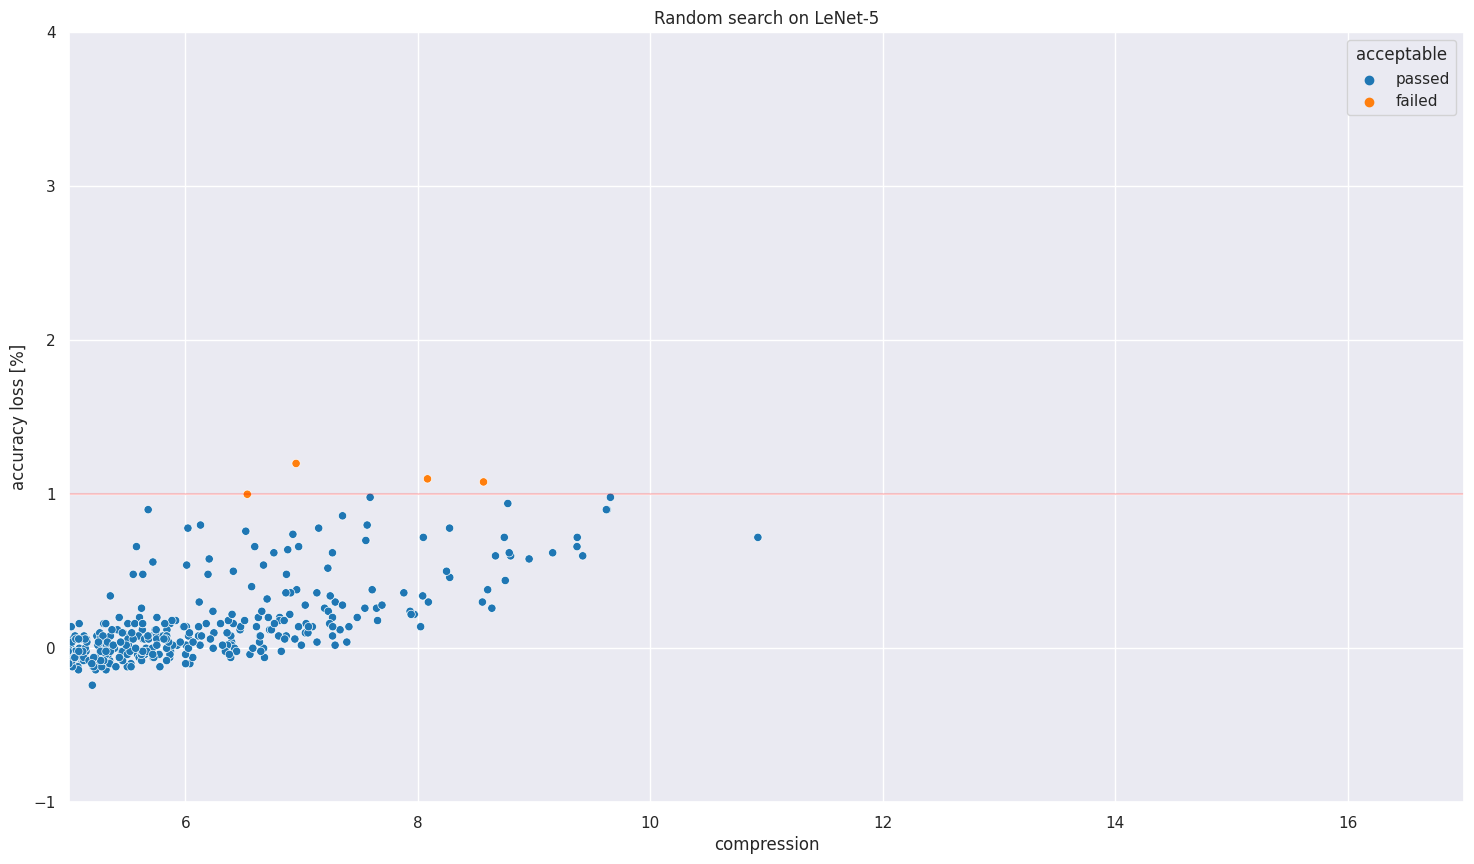

In [10]:
plot_alcr(rnd_data)
plt.title('Random search on LeNet-5')